In [2]:

import psycopg2 as pg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pickle
from datetime import datetime, date, timedelta
import importlib

In [3]:
def get_list_of_dates():

    sdate = date(2020, 2, 23)   # start date
    edate = date(2020, 2, 28)   # end date

    delta = edate - sdate       # as timedelta

    return [pd.Timestamp(sdate + timedelta(days=i)) for i in range(delta.days + 1)]
        
get_list_of_dates()

[Timestamp('2020-02-23 00:00:00'),
 Timestamp('2020-02-24 00:00:00'),
 Timestamp('2020-02-25 00:00:00'),
 Timestamp('2020-02-26 00:00:00'),
 Timestamp('2020-02-27 00:00:00'),
 Timestamp('2020-02-28 00:00:00')]

In [17]:
def print_profit_threshold (y_test, probs, X_test):
    for thresh in np.arange(0, 1.1, .05): # threshes:
        y_pred = probs >= thresh
        cm = confusion_matrix(y_test, y_pred)
        print("*****************************")
        print("thresh:", thresh)
        acc = accuracy_score(y_test, y_pred) * 100
        prec = precision_score(y_test, y_pred) *100
        rec = recall_score(y_test, y_pred) *100
        print (f"Accuracy: {acc:.2f} Precision: {prec:.2f}  Recall:{rec:.2f} ")
        print(cm)
        true_positive_mask = (y_pred==True)&(y_test==True)
        print(true_positive_mask.shape, X_test.shape)
        profit = sum(X_test.cashvalue[true_positive_mask])-sum(y_pred)*.40 - sum(X_test.fee[true_positive_mask]) - sum(X_test.bid[true_positive_mask])/100
        profit_per_bid = profit/sum(y_pred)
        print(f"profit: {profit:.2f}")
        print(f"profit per bid: {profit_per_bid:.2f}")
        winners = X_test[true_positive_mask].groupby("cashvalue").count()
        print(winners.is_winner)
        print("*****************************")
        print("")

In [4]:
print ("Connecting to SQL")
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='password')

print ("Reading Dataset")
df = pd.read_sql ("""Select *  from auction_full where auctiontime >= '2020-01-05'""", conn)

print ("Splitting into Train/Test Sets")
df = df.sort_values("auctiontime")
y = df['is_winner']


Connecting to SQL
Reading Dataset
Splitting into Train/Test Sets


In [73]:
X = df

df['profit'] = df['is_winner'] * (df["cashvalue"] - df["fee"] - df["bid"]/100) -.4
y=df['profit']


In [202]:
df.profit

71593      -0.40
71603      31.34
71602      -0.40
71601      -0.40
71599      -0.40
           ...  
3730343    -0.40
3730345    -0.40
3730346     9.44
3730334    -0.40
3730344    -0.40
Name: profit, Length: 3767914, dtype: float64

In [254]:
import importlib
import BuildModel
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
importlib.reload(BuildModel)

date_list = get_list_of_dates()


#for i in range(1, len(date_list)):
train_cut_off  = datetime(2020, 1, 10) #date_list[i-1]
test_cut_off = datetime(2020, 2, 29) #date_list[i]
print (train_cut_off, test_cut_off)
X_train = X[X.auctiontime <= train_cut_off]
y_train = y[X.auctiontime <= train_cut_off]

X_train = pd.concat([X_train[lose_mask].sample(frac=.1), X_train[win_mask]], axis=0)
y_train = pd.concat([y_train[lose_mask].sample(frac=.1), y_train[win_mask]], axis=0)


X_test = X[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]
y_test = y[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]

2020-01-10 00:00:00 2020-02-29 00:00:00


In [255]:

    #X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)#, random_state=0) 

In [256]:
    
#def create_model():
#    # Define a Keras model
#    model = Sequential()
#
#    # Add a Dense layer that uses the sigmoid function
#    model.add(Dense(units=30, init = 'uniform', activation='relu', input_dim=74))
#    model.add(Dense(units=30, init = 'uniform', activation='relu'))
#    model.add(Dense(units=1, activation='sigmoid'))
#    
#    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model

#clf = KerasClassifier(build_fn=create_model,epochs=8,batch_size=10) #, validation_split=.1)

    
print ("Fitting Model")
pm = BuildModel.PennyModel(RandomForestRegressor(n_estimators=200, n_jobs=-1), is_regressor=True )
pm.fit(X_train, y_train)

Fitting Model
2. Transforming data
4. Fitting model


In [257]:
y_pred = pm.predict(X_test)

2. Transforming data


0


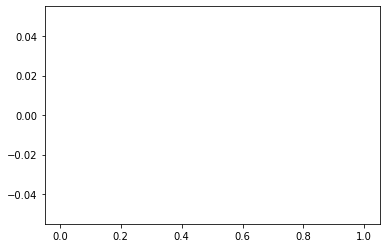

In [258]:
fig, ax = plt.subplots()
mask = y_pred>10
print(sum(mask))
ax.hist(y_pred[mask], bins=200)
fig.show()

In [263]:
for i in np.arange(0, .03, .005):
    print(i,sum(y_test[y_pred>i]))

0.0 18131
0.005 17999
0.01 17816
0.015 17629
0.02 17402
0.025 17178


In [252]:
y = df['is_winner']
y_train = y[X.auctiontime <= train_cut_off]
y_train = pd.concat([y_train[lose_mask].sample(frac=.01), y_train[win_mask]], axis=0)
y_test = y[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]

pm = BuildModel.PennyModel(RandomForestClassifier(n_estimators=200, n_jobs=-1), is_regressor=False )
pm.fit(X_train, y_train)

2. Transforming data
4. Fitting model


In [253]:
print ("Calculating predictions")
probs = pm.predict_proba(X_test)[:,1]
threshes = np.unique(probs)
threshes = threshes[threshes > .4]

print_profit_threshold(y_test, probs, X_test)

Calculating predictions
2. Transforming data
*****************************
thresh: 0.0
Accuracy: 0.53 Precision: 0.53  Recall:100.00 
[[      0 3405157]
 [      0   18218]]
(3423375,) (3423375, 83)
profit: -769107.19
profit per bid: -0.22
cashvalue
6      1937
10     2731
15      106
20     1998
21      157
23      158
25      107
27      208
29       59
30       53
31        4
33     2195
35       15
36      105
37     2507
38      106
40      946
42      157
58      345
62     1872
64     1453
79        6
81        2
83       12
85        1
87      137
100     713
108      10
112      59
162      59
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.05
Accuracy: 0.54 Precision: 0.53  Recall:100.00 
[[    260 3404897]
 [      0   18218]]
(3423375,) (3423375, 83)
profit: -769003.19
profit per bid: -0.22
cashvalue
6      1937
10     2731
15      106
20     1998
21      157
23      158
25      107
27      208
29       59
30       53
31   

Accuracy: 86.62 Precision: 1.97  Recall:49.57 
[[2956358  448799]
 [   9187    9031]]
(3423375,) (3423375, 83)
profit: 25161.08
profit per bid: 0.05
cashvalue
6      1742
10     2232
15       49
20     1226
21       60
23       65
25       34
27       67
29       20
30       16
31        4
33     1057
35       11
36       25
37     1148
38       28
40      301
42       31
58       62
62      412
64      312
79        1
87       15
100      98
108       2
112       7
162       6
Name: is_winner, dtype: int64
*****************************

*****************************
thresh: 0.7000000000000001
Accuracy: 91.78 Precision: 2.41  Recall:36.55 
[[3135204  269953]
 [  11559    6659]]
(3423375,) (3423375, 83)
profit: 33387.33
profit per bid: 0.12
cashvalue
6      1478
10     1776
15       26
20      815
21       36
23       34
25       19
27       37
29       16
30        7
31        2
33      763
35        9
36       11
37      833
38       16
40      190
42       19
58       37
62      265


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 99.47 Precision: 0.00  Recall:0.00 
[[3405157       0]
 [  18218       0]]
(3423375,) (3423375, 83)
profit: 0.00
profit per bid: nan
Series([], Name: is_winner, dtype: int64)
*****************************



/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [142]:

print ("Plotting features")
# Plot the feature importance
feat_scores = pm.get_feature_scores()
feat_scores = feat_scores.sort_values()
fig, ax = plt.subplots()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain')



Plotting features


IndexError: list index out of range

In [106]:
sum(y_pred < 0)

1143137

In [105]:
sum(y_test[y_pred>50])

-2105.0600000003597

In [77]:
sum(X_train.profit==-.4)

3338599

In [76]:
sum(X_train.profit > -.4)

17799

In [56]:
sum(lose_mask) * .01

33385.99